# Exploratory analyses of the healthy volunteers
----

In this notebook we analyze the characteristics of PBMCs of 10 healthy volunteers of varying gender and age.
The PBMCs were purified by blood samples in July 28th, fixed and coated with poly-L-lysine, stained with DAPI, $\gamma$H2AX and Lamin A/C and imaged using a confocal microscope with a resolution of 90nm in x-y and 500nm z-direction. Field of view images were taken of siz 1024x1024x40 (xyz) pixel at 16bit imaging depth.

Nuclei were segmented first in 2D using the max-z projected images. We increased the brightness for segmentation using $\gamma$-correction with $\gamma$ set 0.7. We applied a median filter and Otsu thresholding to obtain binary object masks, which were labeled by identifying the connected components. We filtered out object that were touching the borders and kept only objects which area was within the expected range for nuclei of 72$\mu m^2$ and 450 $\mu m^2$. The remaining nuclei were dilated by one pixel.

To segment the nuclei in 3D we obtained nuclear mask candidates by stacking the identified 2D masks to create 3D pseudo nuclei masks. We multiplied the pseudo mask for each nuclei with the raw image to obtain a preliminary segmentation of the nuclei in 3D. Finally we applied morphological Chan-vese with $\lambda_1$ set to 1 and $\lambda_2$ set to 2. The generation of the pseudo mask reduced the computational complexity and thus the run time, which is why we could set the maximum number of iterations to 300 which allowed fairly quick segmentation of the nuclei with high segmentation quality.

Finally, a number of descriptive features describing the intensity the shape and the texture of the chromatin features were computed in 2D and 3D in addition to intensity-based measures profiling the $\gamma$H2AX and the Lamin A/C protein expression of the individual cells, which finally leads to the data set analyzed in the remainder of this notebook.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
import tifffile
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import sys
import cv2 as cv

sys.path.append("../..")
from src.utils.io import get_file_list

seed = 1234
np.random.seed(seed)
random.seed(seed)

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def read_in_dataset(
    data_dir, feature_file_path, qc_result_file_path, crop_images_path, n_crop_images=9
):
    all_features = []
    nuclei_dict = {}
    subdirs = [f.path for f in os.scandir(data_dir) if f.is_dir()]
    for subdir in tqdm(subdirs, desc="Load data"):
        feature_path = subdir + feature_file_path
        features = pd.read_csv(feature_path, index_col=0)
        features["sample"] = os.path.split(subdir)[1].split("_")[0].lower()
        qc_result_path = subdir + qc_result_file_path
        qc_results = pd.read_csv(qc_result_path, index_col=0)
        features.loc[qc_results.index, "qc_pass"] = qc_results.loc[
            qc_results.index, "qc_pass"
        ]
        all_features.append(features)
        crops_path = subdir + crop_images_path
        nuclei_dict[features["sample"][0]] = get_sample_crops(
            data_dir=crops_path, n_images=n_crop_images
        )
    all_features_df = all_features[0].copy()
    for i in range(1, len(all_features)):
        all_features_df = all_features_df.append(all_features[i])
    return nuclei_dict, all_features_df

<IPython.core.display.Javascript object>

In [3]:
def get_sample_crops(data_dir, n_images=9):
    crop_locs = get_file_list(data_dir)
    selected_crop_locs = np.random.choice(crop_locs, size=n_images, replace=False)
    images = []
    for loc in selected_crop_locs:
        images.append(tifffile.imread(loc))
    return images

<IPython.core.display.Javascript object>

In [4]:
def plot_multi_channel_image_grid(name, images, channel=0, cmap="viridis"):
    nrow = int(np.sqrt(len(images)))
    ncol = int(len(images) / nrow)
    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=[6, 6])
    ax = ax.flatten()
    for i in range(len(ax)):
        ax[i].imshow(
            cv.resize(images[i][channel, :, :], dsize=(64, 64)),
            cmap=cmap,
            vmin=0,
            vmax=2 ** 16,
        )
        ax[i].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle("Sample: {}, channel: {}".format(name.upper(), channel))
    plt.show()
    plt.close()

<IPython.core.display.Javascript object>

In [5]:
def plot_feature_importance(importance, names, model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data = {"feature_names": feature_names, "feature_importance": feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=["feature_importance"], ascending=False, inplace=True)
    fi_df = fi_df.head(20)
    # Define size of bar plot
    plt.figure(figsize=(8, 6))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df["feature_importance"], y=fi_df["feature_names"])
    # Add chart labels
    plt.title(model_type + "FEATURE IMPORTANCE")
    plt.xlabel("FEATURE IMPORTANCE")
    plt.ylabel("FEATURE NAMES")
    plt.show()

<IPython.core.display.Javascript object>

---

## 1. Read in data

First we will read in the data for the different healthy samples. To this end, we will automatically iterate over all subdirectories in a given root data directory. Each subdirectory is expected to include the data corresponding to one of the healthy individuals. If preprocessed using the previously described preprocessing pipeline each of those sub-directories includes the nuclear features corresponding to the respective sub-data set.

In [9]:
root_data_dir = "../../data/comparison/"
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
crop_images_path = "/preprocessed/full_pipeline/segmentation/nuclear_crops_2d"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"

<IPython.core.display.Javascript object>

In [14]:
sample_images, nuclear_features = read_in_dataset(
    data_dir=root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    crop_images_path=crop_images_path,
    n_crop_images=9,
)

Load data: 100%|██████████| 2/2 [00:00<00:00, 24.68it/s]


<IPython.core.display.Javascript object>

---

## 2. Overview of the data

After reading in the data, we will provide a first overview of the data, by plotting 9 randomly sampled, max-z projected nuclei for each biological sample in all three channels.

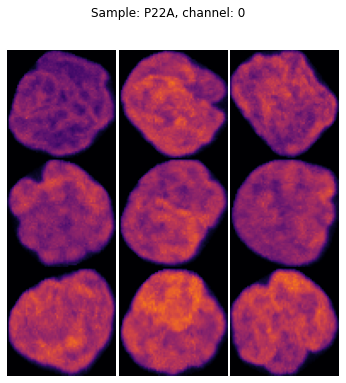

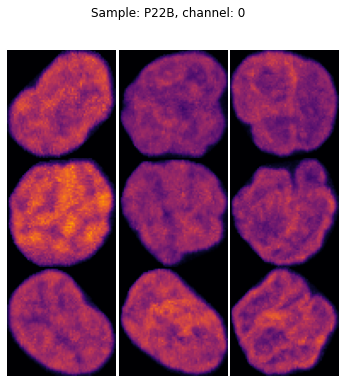

<IPython.core.display.Javascript object>

In [15]:
for k, v in sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=0, cmap="inferno")

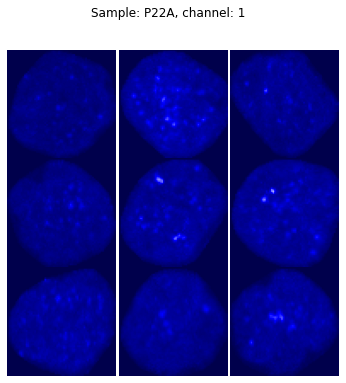

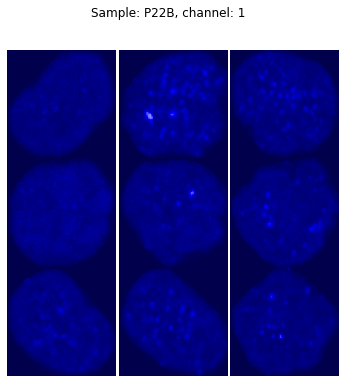

<IPython.core.display.Javascript object>

In [16]:
for k, v in sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=1, cmap="seismic")

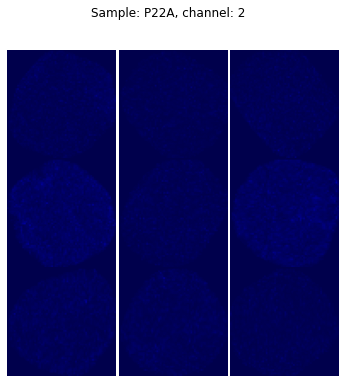

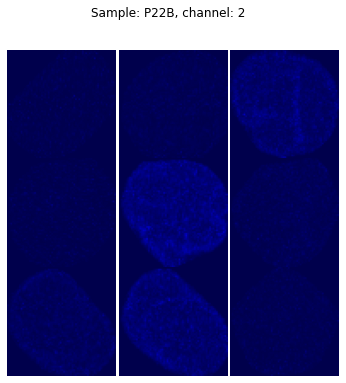

<IPython.core.display.Javascript object>

In [17]:
for k, v in sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=2, cmap="seismic")

The plotted nuclei illustrate the great inter- and intra-sample variability of the chromatin organization and the protein levels in human PBMCs even in healthy patients. In the following we will have a closer look at this heterogneity.

---

## 3. Preprocessing

From now on we will focus on the extracted feature sets for our analyses. To this end, we will first run a basic preprocessing pipeline that
1. Removes nuclei that did not pass the quality checks as flagged by the qc_pass attribute in the data
2. Remove any constant features and nuclei with missing values
3. Remove features correlated with a Pearson correlation of larger than 0.8
4. Normalize the data to unit variance and zero-mean.

In [49]:
filtered_data = nuclear_features.loc[nuclear_features["qc_pass"] == True]
print(
    "Nuclei that did not pass the quality check: {}/{}. Remaining: {}.".format(
        len(nuclear_features) - len(filtered_data),
        len(nuclear_features),
        len(filtered_data),
    )
)

Nuclei that did not pass the quality check: 22/754. Remaining: 732.


<IPython.core.display.Javascript object>

In [50]:
data = filtered_data.loc[:, (filtered_data != filtered_data.iloc[0]).any()]
data = data.dropna(axis=1)
data = data.loc[:, ~data.columns.str.startswith("normalized")]
print(
    "Removed {} constant or features with missing values. Remaining: {}.".format(
        len(filtered_data.columns) - len(data.columns), len(data.columns)
    )
)

Removed 16 constant or features with missing values. Remaining: 261.


<IPython.core.display.Javascript object>

In [51]:
n_nuclei = len(data)
data = data.dropna()
print(
    "Removed {}/{} nuclei with missing values. Remaining: {}".format(
        n_nuclei - len(data), n_nuclei, len(data)
    )
)

Removed 0/732 nuclei with missing values. Remaining: 732


<IPython.core.display.Javascript object>

In [52]:
# Deselect label and sample column and remove some other unimportant features
numeric_data = data.iloc[:, 1:-1].drop(
    ["centroid-0", "centroid-1", "orientation"], axis=1
)

<IPython.core.display.Javascript object>

In [53]:
# Maintain features that have at most a Pearson correlation of 0.8
threshold = 0.8

# Control data
data_corr = numeric_data.corr().abs()
upper = data_corr.where(np.triu(np.ones(data_corr.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(
    "Removed {}/{} features with a Pearson correlation above {}. Remaining: {}".format(
        len(to_drop),
        len(numeric_data.columns),
        threshold,
        len(numeric_data.columns) - len(to_drop),
    )
)
numeric_data = numeric_data.drop(to_drop, axis=1)
# numeric_data = numeric_data.loc[:, ~numeric_data.columns.str.contains("gh2ax")]

Removed 191/256 features with a Pearson correlation above 0.8. Remaining: 65


<IPython.core.display.Javascript object>

In [54]:
num_data_sc = pd.DataFrame(
    StandardScaler().fit_transform(numeric_data),
    index=numeric_data.index,
    columns=numeric_data.columns,
)
num_data_sc.head()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,med_radius,concavity,area_bbarea,avg_curvature,std_curvature,npolarity_changes,...,min_dna_3d_int,q75_dna_3d_int,rel_gh2ax_2d_int,max_gh2ax_2d_int,q25_gh2ax_2d_int,kurtosis_gh2ax_2d_int,q75_gh2ax_3d_int,rel_lamin_2d_int,q25_lamin_2d_int,kurtosis_lamin_2d_int
P22_1_PBMCs_Dapi_gH2AX_LaminA_C_11_10_21_2X_16bit_2X_1_0,-1.696407,-0.511754,-1.234960,-2.542678,-0.786788,1.463653,-1.041192,0.553479,1.543801,-1.878694,...,1.306578,-0.062155,0.470560,-0.607310,-0.998725,-0.589214,-0.076430,-0.450122,-0.578020,0.358836
P22_1_PBMCs_Dapi_gH2AX_LaminA_C_11_10_21_2X_16bit_2X_1_1,1.064396,-0.690222,1.597023,1.237878,0.273408,-0.931666,0.510140,-0.079198,-0.380897,0.301801,...,2.485055,-0.423637,1.227115,-0.623368,0.191029,-0.645441,-0.740140,-0.376401,-0.093836,0.099673
P22_1_PBMCs_Dapi_gH2AX_LaminA_C_11_10_21_2X_16bit_2X_1_2,-1.302007,0.023649,-1.259941,-0.765807,-0.548293,-0.058538,1.669133,0.551020,-0.539316,-0.960590,...,0.410463,1.556986,1.034518,0.540728,2.075985,0.090375,1.650769,3.317187,6.868705,-1.706796
P22_1_PBMCs_Dapi_gH2AX_LaminA_C_11_10_21_2X_16bit_2X_1_3,-0.513206,-0.690222,0.057099,-2.778355,-0.650544,2.271637,-0.886147,0.111445,0.758046,-1.190116,...,1.464556,-0.370921,0.330163,-1.042030,0.060679,-0.696373,-0.235565,-0.491671,-0.116404,0.618886
P22_1_PBMCs_Dapi_gH2AX_LaminA_C_11_10_21_2X_16bit_2X_1_4,-0.710406,-1.582562,0.683412,-0.100040,-1.603858,-0.280085,0.827561,1.029635,0.570826,-0.157250,...,1.016952,2.942669,1.572805,0.771151,2.002407,-0.002567,3.246003,-0.412084,-0.006984,0.126809


<IPython.core.display.Javascript object>

---

## 4. Overview of the nuclear space.

The tSNE plot below further emphasizes the heterogeneity in the nuclear population. Interestingly, however we can see some indication for a preferential grouping of the nuclei of the healthy volunteer 1,9 and 10 in contrast to the remaining samples.

In [55]:
tsne = TSNE(random_state=seed)
tsne_embs = tsne.fit_transform(num_data_sc)
tsne_embs = pd.DataFrame(
    tsne_embs, columns=["tsne_0", "tsne_1"], index=num_data_sc.index
)
tsne_embs.loc[:, "sample"] = np.array(data.loc[tsne_embs.index, "sample"])

<IPython.core.display.Javascript object>

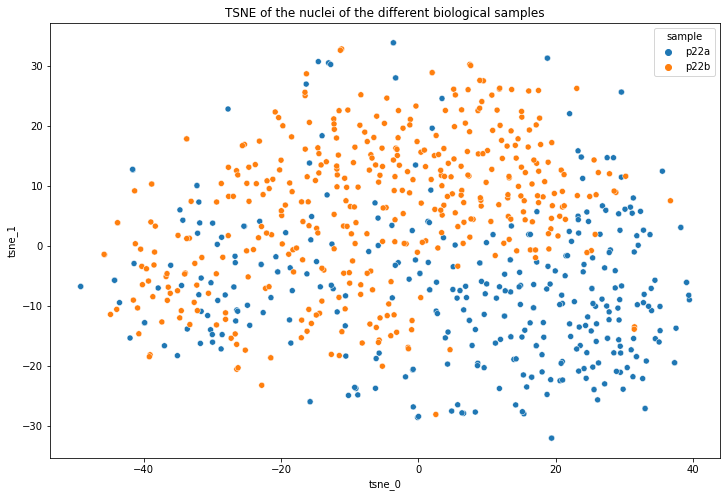

<IPython.core.display.Javascript object>

In [56]:
fig, ax = plt.subplots(figsize=[12, 8])
sns.scatterplot(data=tsne_embs, x="tsne_0", y="tsne_1", hue="sample", ax=ax)
plt.title("TSNE of the nuclei of the different biological samples")
plt.show()

Those grouping might however be artifacts due to the projection as they cannot be explained by the days the experiment were taken, the imaging setup that was kept constant for all samples or the age/sex as both groups capture a heterogenous distribution of these features.

In [29]:
rfc = RandomForestClassifier(random_state=seed)
skf = StratifiedKFold(10)
features = np.array(num_data_sc)
# labels = LabelEncoder(np.array(data.loc[]))
labels = np.array(data.loc[:, "sample"])

confusion_mtx = np.zeros([2, 2])
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    rfc.fit(X_train, y_train)
    confusion_mtx += confusion_matrix(y_test, rfc.predict(X_test), normalize="true")
confusion_mtx /= 10

<IPython.core.display.Javascript object>

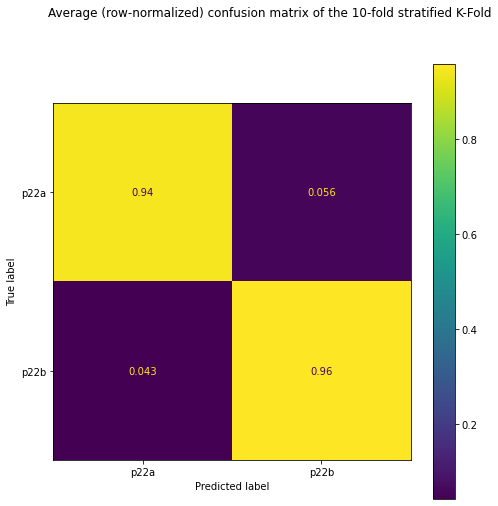

<IPython.core.display.Javascript object>

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(
    confusion_mtx,
    display_labels=["p22a", "p22b"],
)
disp.plot(ax=ax)
fig.suptitle(
    "Average (row-normalized) confusion matrix of the 10-fold stratified K-Fold"
)
plt.show()

We see that the classifier performs significantly better than chance and especially well on samples from the healthy volunteers 2,5,9 and 10. Let us check which of those features are most indicative for that.

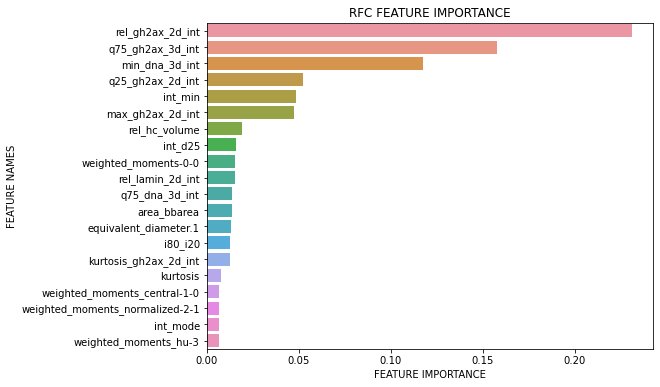

<IPython.core.display.Javascript object>

In [31]:
rfc = rfc.fit(features, labels)
plot_feature_importance(rfc.feature_importances_, num_data_sc.columns, "RFC ")

As expected most of the most discriminative features between the samples are related to the intensity. Interestingly, the majority of those related to the two protein channels.